In [1]:
""" This module implements the base function to implement a VQE for a Ising Chain with Transverse Field. """
from pennylane import numpy as np

import sys
sys.path.insert(0, '../')
import vqe as vqe
import annni_model as annni
import qcnn as qcnn
import visualization as qplt
import losses
import general as qmlgen

In [2]:
Ns = [4,6,8,10,12]
side = 100


In [3]:
path = '../data/vqes/ANNNI/'
pathplots = '../data/plots/'

train_index_line  = np.arange(0,2*side-1)
train_index_edges = np.array([0,side-1,2*side-1])

In [4]:
vqes = []
for N in Ns:
    try:
        filename = 'N'+str(N)+'n'+str(side)
        vqes.append(vqe.load_vqe(path + filename) )
        print('{0} loaded sucessfully'.format(path+filename))
    except:
        print('{0} not found'.format(path+filename))

../data/vqes/ANNNI/N4n100 loaded sucessfully
../data/vqes/ANNNI/N6n100 loaded sucessfully
../data/vqes/ANNNI/N8n100 loaded sucessfully
../data/vqes/ANNNI/N10n100 loaded sucessfully
../data/vqes/ANNNI/N12n100 loaded sucessfully


In [5]:
cents = qmlgen.findC(*vqes[:-1], width = .15)

In [6]:
lr = .1
epoch = 10000

Cost: 0.10047672688961029: 100%|██████████| 10000/10000 [01:04<00:00, 153.88it/s]


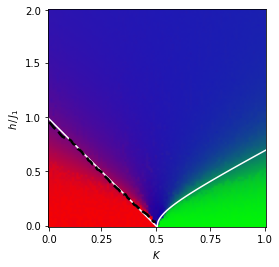

In [8]:
myqcnn = qcnn.qcnn(vqes[1], qcnn.qcnn_circuit, n_outputs = 2)
myqcnn.train(lr, epoch, train_index_line, losses.cross_entropy)
qplt.show_QCNN_classificationANNNI(myqcnn, hard_thr = False, deltaeline = cents)

In [13]:
lines = np.concatenate((np.arange(side), np.arange(1,side)*side))
points = np.array([0,side-1,side*side - side])

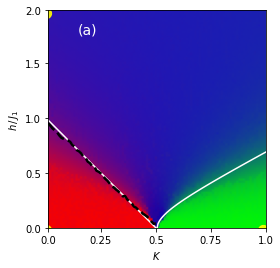

In [14]:
qplt.show_QCNN_classificationANNNI(myqcnn, hard_thr = False, deltaeline = cents, train_index = points, label = 'a')

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm, Normalize
import plotly.graph_objects as go
import pandas as pd


def show_QCNN_classificationANNNI(qcnnclass, hard_thr = True, lines = False, deltaeline = [], train_index = [], label = False):
    circuit = qcnnclass.vqe_qcnn_circuit
    side = int(np.sqrt(qcnnclass.n_states))
    
    if hard_thr:
        @qml.qnode(qcnnclass.device, interface="jax")
        def qcnn_circuit_prob(params_vqe, params):
            circuit(params_vqe, params)
        
            return [qml.probs(wires=int(k)) for k in qcnnclass.final_active_wires]
        
        vcircuit = jax.vmap(lambda v: qcnn_circuit_prob(v, qcnnclass.params), in_axes=(0))
    
        predictions = np.array(np.argmax(vcircuit(qcnnclass.vqe_params), axis = 2))
        c = []
        for pred in predictions:
            if (pred == [0,1]).all():
                c.append(0)
            elif (pred == [1,1]).all():
                c.append(1)
            elif (pred == [1,0]).all():
                c.append(2)
            else: c.append(3)

        phases = mpl.colors.ListedColormap(["lightcoral", "skyblue",
                                            "black", "palegreen"])
        norm = mpl.colors.BoundaryNorm(np.arange(0,4), phases.N) 
        plt.imshow( np.rot90(np.reshape(c, (side, side) )), 
                                      cmap = phases, norm = norm)
    else:
        @qml.qnode(qcnnclass.device, interface="jax")
        def qcnn_circuit_prob(params_vqe, params):
            circuit(params_vqe, params)
        
            return qml.probs([int(k) for k in qcnnclass.final_active_wires])
        
        vcircuit = jax.vmap(lambda v: qcnn_circuit_prob(v, qcnnclass.params), in_axes=(0))
    
        predictions = np.array(vcircuit(qcnnclass.vqe_params) )
        
        c = []
        
        # define color map 
        color_map = {1: np.array([255, 0, 0]), # red
                     2: np.array([0, 255, 0]), # green
                     3: np.array([0, 0, 255])} # blue
        
        rgb_probs = np.ndarray(shape=(side*side, 3), dtype=float)
        
        for i, pred in enumerate(predictions):
            rgb_probs[i] = [pred[1]*255,pred[2]*255,pred[3]*255]
        rgb_probs = np.rot90(np.reshape(rgb_probs, (side,side,3)) )/255
        
        plt.imshow( rgb_probs )
        
    plt.ylabel(r'$h\,/\,J_1$')
    plt.xlabel(r'$K$')
    
    def getlines(func, xrange, side, color, res = 100):
        xs = np.linspace(xrange[0], xrange[1], res)
        ys = func(xs)
        
        plt.plot(side*xs -.5, side - ys*side/2 -.5, color = color)
        
    def B2SA(x):
        return 1.05 * np.sqrt((x-.5)*(x-.1))
    
    def ferropara(x):
        return 1 - 2*x
                    
    getlines(B2SA, [.5,1], side, 'white', res = 100)
    getlines(ferropara, [0,.5], side, 'white', res = 100)
    
    x = np.linspace(1, 0, side)
    y = np.linspace(0, 2, side)

    plt.xticks(ticks=np.linspace(0,side-1,5).astype(int), labels= [np.round(k*1/4,2) for k in range(0,5)] )
    plt.yticks(ticks=np.linspace(0,side-1,5).astype(int), labels= [np.round(k*2/4,2) for k in range(4,-1,-1)])
    
    if len(deltaeline)>0:
        plt.plot([side/2]*int(side/2) + (side/2) * deltaeline, '--', color ='black', lw= 2.5)
        
    if len(train_index)>0:
        x_star, y_star = [], []
        for idx in train_index:
            x_star.append(idx//side - 1)
            y_star.append(side - idx%side )
        plt.scatter(x_star, y_star, marker = 'o', color = 'yellow', s = 105, alpha =.9)
        plt.ylim(side-1,0)
        plt.xlim(0,side-1)
    
    if label:
        plt.figtext(.33, .8, '('+label+')', color = 'white', fontsize=14)